### 0. ALL NECESSARY IMPORTS

In [ ]:
# all necessary imports
import numpy as np 
import pandas as pd 
import re
from collections import Counter
import os
import json
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import transformers
import torch
import torch.nn as nn
from transformers import BertModel
from torch.utils.data import Dataset
from datasets import Dataset
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoTokenizer, BertModel, AdamW, CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader
from argparse import Namespace
from pathlib import Path
import aiohttp
from torch.amp import autocast, GradScaler
import asyncio
import aiofiles
from tqdm.asyncio import tqdm_asyncio
import requests
import subprocess
from collections import Counter
from tqdm import tqdm
import cv2
from PIL import Image 
import time
from requests.exceptions import HTTPError
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!pip install --upgrade ipywidgets

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
!jupyter nbextension install --py --symlink --sys-prefix ipywidgets
!jupyter nbextension enable --py --sys-prefix ipywidgets

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbextension", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 972, in start
    super().start()
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 270, in start
    self.subapp.start()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 702, in start
    self.install_extensions()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 675, in install_extensions
    full_dests = install(self.extra_args[0],
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 203, 

In [6]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00


In [7]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### 1. GET DATA

#### tgif-mc

tgif-mc dataset is divided into 2 main multiple choice tasks:
- REPEATING ACTION 
    - example: "What does the cat do 3 times?" - "Put head down"
    - train: 20,475, test: 2,274, total: 22,749
- STATE TRANSITION 
    - example: "What does the model do after lower coat?" - "Pivot around"
    - train: 52,704, test: 6,232, total: 58,936

In this notebook only RA set is considered.

In [8]:
def clean_dataframe(file_path, column_mapping, id_prefix='mc'):
    """
    Preprocess the test DataFrame by renaming columns, reordering columns, and modifying IDs.

    Args:
        file_path (str): Path to the CSV file to be loaded.
        column_mapping (dict): Dictionary for renaming columns (e.g., {'gif_name': 'title', 'vid_id': 'clip_name', 'key': 'id'}).
        id_prefix (str): Prefix to add to IDs in the 'id' column.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    # Load the CSV file
    df = pd.read_csv(file_path, sep='\t')

    # Rename columns
    df = df.rename(columns=column_mapping)

    # Modify 'id' column
    if 'id' in df.columns:
        df['id'] = df['id'].apply(lambda x: f'{id_prefix}{x}' if pd.notnull(x) else x)

    # Reorder columns 
    expected_columns = ['title', 'id', 'clip_name', 'question', 'a1', 'a2', 'a3', 'a4', 'a5', 'answer']
    df = df[[col for col in expected_columns if col in df.columns]]

    return df

In [9]:
column_mapping = {
    'gif_name': 'title',
    'vid_id': 'clip_name',
    'key': 'id'
}

In [10]:
# REPEATING ACTION DATA
train_ra = '/kaggle/input/tgif-mc/Train_action_question.csv'
test_ra = '/kaggle/input/tgif-mc/Test_action_question.csv'

# Clean the DataFrames
df_train_ra = clean_dataframe(train_ra, column_mapping)
df_test_ra = clean_dataframe(test_ra, column_mapping)

# Display the result
print(df_train_ra.head())
print(df_test_ra.head())

                            title    id clip_name  \
0  tumblr_nqc2mbmU2J1uxhtnwo1_400   mc5   ACTION1   
1  tumblr_nd53vw6Crc1r7na6zo1_400  mc16   ACTION2   
2  tumblr_nekvrnW3rh1sxaoaro1_400  mc21   ACTION3   
3  tumblr_npvbzhDifH1sgulfgo1_250  mc33   ACTION5   
4  tumblr_nexzlj5e6C1u2tewlo1_250  mc35   ACTION6   

                                            question             a1  \
0                   What does the woman do 4 times ?          flick   
1                     What does the man do 5 times ?  tug baby arms   
2                   What does the woman do 5 times ?  vibrate hands   
3  What does the woman do 10 or more than 10 times ?           snap   
4                   What does the woman do 6 times ?    pull a doll   

                           a2              a3                         a4  \
0                do gymnastic       chew food  shake hips left and right   
1          go around the cons            grab                 pushes off   
2  holds a phone towards f

In [11]:
subset_size = 10000
subset_df = df_train_ra[:subset_size]  # Select the first 10000 rows

In [12]:
subset_test = 1000
subset_df_test = df_test_ra[:subset_test]  # Select the first 1000 rows

### 2. PREPROCESS DATA

Let's define a single preprocessig fucntion, so to have more compactness

In [14]:
# Load necessary resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def preprocess_dataframe(df, text_columns, remove_stopwords=True, lemmatize=True, tokenize=True):
    """
    Preprocess a DataFrame by cleaning text data in specified columns.

    Args:
        df (pd.DataFrame): Input DataFrame containing text data.
        text_columns (list): List of column names to preprocess.
        remove_stopwords (bool): Whether to remove stopwords.
        lemmatize (bool): Whether to lemmatize text.
        tokenize (bool): Whether to tokenize text.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """

    def contains_special_characters(value):
        """Check for special characters in a string."""
        pattern = r'[^a-zA-Z0-9?\s]'
        return bool(re.search(pattern, value)) if isinstance(value, str) else False

    def remove_and_concatenate(text):
        """Remove 'tumblr' and concatenate remaining parts."""
        parts = text.split()
        if len(parts) > 1 and parts[0].lower() == 'tumblr':
            return ''.join(parts[1:])
        return text

    def remove_punctuation(text):
        """Remove punctuation from text."""
        return text.translate(str.maketrans('', '', string.punctuation))

    def remove_stopwords_func(text):
        """Remove stopwords from text."""
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])

    def lemmatize_with_spacy(text):
        """Lemmatize text using Spacy."""
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])

    def tokenize_text(text):
        """Tokenize text."""
        return word_tokenize(text) if isinstance(text, str) else []

    # Remove NaN values
    df = df.dropna(subset=text_columns)

    # Replace special characters
    for col in text_columns:
        df[col] = df[col].apply(lambda x: remove_and_concatenate(str(x)) if contains_special_characters(x) else str(x))

    # Convert to lowercase
    df[text_columns] = df[text_columns].map(str.lower)

    # Remove punctuation
    df[text_columns] = df[text_columns].map(remove_punctuation)

    # Remove extra whitespace
    df[text_columns] = df[text_columns].map(str.strip)

    # Remove stopwords
    if remove_stopwords:
        df[text_columns] = df[text_columns].map(remove_stopwords_func)

    # Lemmatize
    if lemmatize:
        for col in text_columns:
            df[col] = df[col].apply(lemmatize_with_spacy)

    # Tokenize
    if tokenize:
        for col in text_columns:
            df[col] = df[col].apply(tokenize_text)

    return df

In [16]:
# Columns to preprocess
text_columns = ['title', 'question', 'a1', 'a2', 'a3', 'a4', 'a5']

In [17]:
# REPEATING ACTION -> preprocessing
preprocessed_df_train_ra = preprocess_dataframe(subset_df, text_columns)
preprocessed_df_test_ra = preprocess_dataframe(df_test_ra, text_columns)

In [18]:
preprocessed_df_train_ra.head()

,title,id,clip_name,question,a1,a2,a3,a4,a5,answer
0,[tumblrnqc2mbmu2j1uxhtnwo1400],mc5,ACTION1,"[woman, 4, time]",[flick],[gymnastic],"[chew, food]","[shake, hip, leave, right]","[pat, back, man]",2
1,[tumblrnd53vw6crc1r7na6zo1400],mc16,ACTION2,"[man, 5, time]","[tug, baby, arm]","[go, around, con]",[grab],[push],"[wave, head]",4
2,[tumblrnekvrnw3rh1sxaoaro1400],mc21,ACTION3,"[woman, 5, time]","[vibrate, hand]","[hold, phone, towards, face]","[sway, hip]","[wag, hand]","[point, somewhere]",2
3,[tumblrnpvbzhdifh1sgulfgo1250],mc33,ACTION5,"[woman, 10, 10, time]",[snap],"[skip, back, worth]","[shake, fist]","[jump, tub]",[move],2
4,[tumblrnexzlj5e6c1u2tewlo1250],mc35,ACTION6,"[woman, 6, time]","[pull, doll]","[take, step]","[hand, award]",[tilt],"[point, another, kid]",1


In [19]:
print(preprocessed_df_train_ra["answer"].value_counts())

answer
1    2041
3    2022
4    2011
0    1964
2    1962
Name: count, dtype: int64


### 3. CREATE MC DATASET

In [21]:
class MultipleChoiceDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        """
        Args:
            dataset: A Pandas DataFrame or similar structure with the dataset.
            tokenizer: A tokenizer instance (e.g., from HuggingFace Transformers).
            max_length: Maximum sequence length for tokenization.
        """
        self.dataset = dataset  # Use 'dataset' instead of 'data'
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if isinstance(idx, (int, np.integer)): 
            # Fetch a single row (adjust this based on your data structure)
            row = self.dataset.iloc[idx]
    
            # Extract fields for question, choices, and correct answer
            question = row["question"]  
            choices = [row['a1'], row['a2'], row['a3'], row['a4'], row['a5']]
            correct_answer = row["answer"]  
            
            # Tokenize each question-choice pair
            inputs = self.tokenizer(
                [f"{question} {choice}" for choice in choices],
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
    
            # Return tokenized inputs and labels
            return {
                "input_ids": inputs["input_ids"],  # Shape: (num_choices, seq_length)
                "attention_mask": inputs["attention_mask"],  # Shape: (num_choices, seq_length)
                "labels": torch.tensor(correct_answer, dtype=torch.long)  
            }

        elif isinstance(idx, (list, np.ndarray)):  # Multiple indices
            batch = [self.__getitem__(i) for i in idx]  # Recursively fetch rows
            return {
                "input_ids": torch.stack([item["input_ids"] for item in batch]),
                "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
                "labels": torch.stack([item["labels"] for item in batch]),
            }

In [22]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_dataset_ra = MultipleChoiceDataset(preprocessed_df_train_ra, tokenizer)
test_dataset_ra = MultipleChoiceDataset(preprocessed_df_test_ra, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
# Extract labels from train_dataset_ra
labels = []
for i in range(len(train_dataset_ra)):
    labels.append(train_dataset_ra[i]["labels"].item())  # Access label as an integer

# Count occurrences of each label
label_counts = Counter(labels)

# Print the counts
for label, count in label_counts.items():
    print(f"Label {label}: {count} occurrences")

Label 2: 1962 occurrences
Label 4: 2011 occurrences
Label 1: 2041 occurrences
Label 0: 1964 occurrences
Label 3: 2022 occurrences


### 4. TEXT ENCODER

In [24]:
class MaskedAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MaskedAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        if attention_mask is not None:
            # Shape: [batch_size, seq_len]
            batch_size, seq_len = attention_mask.size()
            #print('batch_size', batch_size) -> 40 (old_batch_size * num_choices)

            # Expand mask for multi-head attention
            # Shape: [batch_size, 1, 1, seq_len]
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

            # Broadcast to match [batch_size, num_heads, seq_len, seq_len]
            attention_mask = attention_mask.expand(batch_size, self.num_heads, seq_len, seq_len)

            # Convert to the correct format for MultiheadAttention
            # Collapse `batch_size * num_heads` into one dimension
            attention_mask = attention_mask.reshape(-1, seq_len, seq_len)

            # Set masked values to -inf and others to 0
            attention_mask = attention_mask.float().masked_fill(attention_mask == 0, float('-inf')).masked_fill(attention_mask == 1, 0)

        # Perform multi-head attention
        attn_output, _ = self.multihead_attn(x, x, x, attn_mask=attention_mask)
        x = self.layer_norm(x + self.dropout(attn_output))  # Add & Norm

        # Feed-forward network
        ff_output = self.feed_forward(x)
        return self.layer_norm(x + self.dropout(ff_output))  # Add & Norm

In [25]:
class TextEncoder(nn.Module):
    def __init__(self, bert_model_name, num_heads, num_layers, max_length, embed_dim, dropout=0.1):
        """
        Initialize the TextEncoder with BERT embeddings and masked attention layers.
        
        Args:
            bert_model_name (str): Name of the pre-trained BERT model (e.g., 'bert-base-uncased').
            num_heads (int): Number of attention heads.
            num_layers (int): Number of masked attention layers.
            max_length (int): Maximum sequence length.
            embed_dim (int): Embedding dimension (should match BERT hidden size).
            dropout (float): Dropout rate for attention layers.
        """
        super(TextEncoder, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Ensure BERT embeddings match the input dimension
        assert embed_dim == self.bert.config.hidden_size, \
            f"embed_dim ({embed_dim}) must match BERT hidden size ({self.bert.config.hidden_size})."

        # Masked attention layers
        self.layers = nn.ModuleList([
            MaskedAttention(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])

        # Fully connected output layer
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, input_ids, attention_mask, num_choices=5):
        """
        Forward pass for the TextEncoder.

        Args:
            input_ids (torch.Tensor): Input token IDs of shape [batch_size, seq_len].
            attention_mask (torch.Tensor): Attention mask of shape [batch_size, seq_len].

        Returns:
            torch.Tensor: Output embeddings of shape [batch_size, seq_len, embed_dim].
        """
        # Get BERT embeddings
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_output.last_hidden_state  # Shape: [batch_size, seq_len, embed_dim]

        # Pass through masked attention layers
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)

        x = self.fc_out(x) # shape: [batch_size*num_choices, seq_len, embed_dim]

        # Reshape back to [batch_size, num_choices, seq_len, embed_dim]
        #batch_size = input_ids.size(0) // num_choices
        #x = x.view(batch_size, num_choices, x.size(1), x.size(2))
        
        # Final output 
        return x

In [26]:
text_encoder = TextEncoder(
    bert_model_name="bert-base-uncased",
    num_heads=8,
    num_layers=2,
    max_length=128, 
    embed_dim=768
).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(text_encoder.parameters(), lr=5e-5)

# Training parameters
epochs = 10  # Adjust 
batch_size = 16 
train_loader = DataLoader(train_dataset_ra, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    text_encoder.train()  # Set the model to training mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    # Training Loop
    num_choices = 5  # Number of choices per question
    
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)  # Shape: [batch_size, num_choices, seq_len]
        attention_mask = batch["attention_mask"].to(device)  # Same shape as input_ids
        labels = batch["labels"].to(device)  # Shape: [batch_size]
    
        # Flatten choices dimension for input to text_encoder
        input_ids = input_ids.view(-1, input_ids.size(-1))  # [batch_size * num_choices, seq_len]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))  # Same shape
    
        # Forward pass through the text encoder
        outputs = text_encoder(input_ids, attention_mask)  # [batch_size * num_choices, seq_len, hidden_size]
    
        # Pooling: Use the CLS token embedding or mean pooling
        pooled_outputs = outputs[:, 0, :]  # Use CLS token embedding
        # Alternatively, for mean pooling: pooled_outputs = outputs.mean(dim=1)
    
        # Reshape logits to [batch_size, num_choices]
        logits = pooled_outputs.view(-1, num_choices, pooled_outputs.size(-1))  # [batch_size, num_choices, hidden_size]
    
        # Reduce logits to [batch_size, num_choices] (classification head)
        logits = logits.mean(dim=-1)  # Reduce hidden_size dimension
    
        # Compute loss
        loss = loss_fn(logits, labels)  # Labels shape: [batch_size]
    
        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=1)  # Shape: [batch_size]
        correct_predictions = (predictions == labels).sum().item()
        total_correct += correct_predictions
        total_samples += labels.size(0)
    
    # Calculate epoch metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{epochs}, Accuracy: {epoch_accuracy:.4f}")

'\n# Define loss function and optimizer\nloss_fn = nn.CrossEntropyLoss()\noptimizer = torch.optim.AdamW(text_encoder.parameters(), lr=5e-5)\n\n# Training parameters\nepochs = 10  # Adjust \nbatch_size = 16 \ntrain_loader = DataLoader(train_dataset_ra, batch_size=batch_size, shuffle=True)\n\n# Training loop\nfor epoch in range(epochs):\n    text_encoder.train()  # Set the model to training mode\n    total_loss = 0\n    total_correct = 0\n    total_samples = 0\n\n    # Training Loop\n    num_choices = 5  # Number of choices per question\n    \n    for batch in train_loader:\n        input_ids = batch["input_ids"].to(device)  # Shape: [batch_size, num_choices, seq_len]\n        attention_mask = batch["attention_mask"].to(device)  # Same shape as input_ids\n        labels = batch["labels"].to(device)  # Shape: [batch_size]\n    \n        # Flatten choices dimension for input to text_encoder\n        input_ids = input_ids.view(-1, input_ids.size(-1))  # [batch_size * num_choices, seq_len]\n

### 5. VIDEO PREPROCESSING & CLIP

In [28]:
# Get the set of allowed GIF names from the DataFrame
train_ra_allowed_titles = set(preprocessed_df_train_ra['title'].apply(lambda x: x[0] if isinstance(x, list) and x else None))
test_ra_allowed_titles = set(preprocessed_df_test_ra['title'].apply(lambda x: x[0] if isinstance(x, list) and x else None))


In [30]:
# Path to TSV file
tsv_file = "/kaggle/input/tgif-mc-video/tgif-v1.0.tsv"

In [31]:
# Load CLIP model and processor from Hugging Face
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [32]:
# Directories for downloaded GIFs
output_dir_train_ra = "/kaggle/working/downloaded_gifs_train_ra"
os.makedirs(output_dir_train_ra, exist_ok=True)

- Download gifs

In [33]:
# Allowed titles per category
allowed_titles_dict = {
    "train_ra": train_ra_allowed_titles,
}

# Output directories for each category
category_dirs = {
    "train_ra": output_dir_train_ra,
}

- Get embeddings for frames extracted from gifs

In [34]:
def extract_video_embeddings(video_path, model, processor, device):
    """
    Extract video embeddings from the provided video file.

    Args:
        video_path (str): Path to the video file.
        model: Pre-trained model to generate embeddings.
        processor: Pre-trained processor for the model.
        device: CPU or GPU for computation.

    Returns:
        numpy.ndarray: Video embeddings for the video with shape (num_frames, embedding_size).
    """
    video_obj = cv2.VideoCapture(video_path)
    success, frame = True, None
    frame_embeddings = []

    while success:
        success, frame = video_obj.read()
        if not success or frame is None:
            break

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Extract frame embedding
        image_pil = Image.fromarray(frame)
        inputs = processor(images=image_pil, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
            embedding = outputs.cpu().numpy()
        frame_embeddings.append(embedding)

    video_obj.release()

    if len(frame_embeddings) == 0:
        # Return an empty array with the second dimension matching embedding size
        return np.empty((0, model.get_image_features(**inputs).size(-1)))
    else:
        # Stack embeddings and ensure consistent shape
        embeddings = np.vstack(frame_embeddings)
        return embeddings

### 6. DATASET OF TEXT-VIDEO EMBEDDINGS PAIRS

In [35]:
def Paired_Dataset_with_Embeddings(tsv_file, category_dirs, allowed_titles_dict, preprocessed_df_train_ra, train_dataset_ra, text_encoder, model, processor, device, max_length, gif_limit=20):
    """
    Create a dataset of paired text embeddings, video embeddings, and labels with GIF alignment verification.
    
    Args:
        tsv_file: Path to the TSV file containing GIF metadata.
        category_dirs: Dictionary of category names and their directories.
        allowed_titles_dict: Dictionary of allowed titles per category.
        preprocessed_df_train_ra: DataFrame containing raw text and titles.
        train_dataset_ra: Instance of MultipleChoiceDataset containing tokenized text data.
        text_encoder: Instance of the TextEncoder model.
        model: Pre-trained model for video embeddings.
        processor: Pre-trained processor for video embeddings.
        device: CPU or GPU for computation.
        max_length: Maximum token length for text inputs.
        gif_limit: Maximum number of GIFs to process.

    Returns:
        List of dictionaries with text embeddings, video embeddings, and labels.
    """
    paired_dataset = []
    counters = {category: 0 for category in category_dirs}
    processed_gifs = 0

    # Load the TSV file into a dictionary for fast lookup
    gif_url_map = {}
    with open(tsv_file, "r") as file:
        for line in file:
            gif_url = line.split("\t")[0]
            gif_name_with_extension = os.path.basename(gif_url).replace("_", "")
            gif_name = gif_name_with_extension.rsplit('.', 1)[0]
            gif_url_map[gif_name] = gif_url

    # Move text_encoder to the correct device
    text_encoder.to(device)

    # Iterate over titles in preprocessed_df_train_ra
    for idx, row in preprocessed_df_train_ra.iterrows():
        title = row['title'][0]
        if title not in gif_url_map:
            continue

        # Get the corresponding GIF URL and metadata
        gif_url = gif_url_map[title]
        gif_name_with_extension = os.path.basename(gif_url).replace("_", "")
        gif_name = gif_name_with_extension.rsplit('.', 1)[0]

        # Identify the category for the GIF
        category = None
        for cat, allowed_titles in allowed_titles_dict.items():
            if gif_name in allowed_titles:
                category = cat
                break
        if category is None:
            continue

        # Download the GIF
        gif_path = os.path.join(category_dirs[category], gif_name_with_extension)
        try:
            response = requests.get(gif_url, stream=True, timeout=10)
            response.raise_for_status()
            with open(gif_path, "wb") as gif_file:
                for chunk in response.iter_content(chunk_size=8192):
                    gif_file.write(chunk)
        except requests.RequestException as e:
            print(f"Failed to download {gif_url}: {e}")
            continue

        # Extract video embeddings
        try:
            video_embeddings = extract_video_embeddings(gif_path, model, processor, device)
        except Exception as e:
            print(f"Failed to extract embeddings for {gif_path}: {e}")
            continue

        # Get tokenized data from train_dataset_ra
        text_data = train_dataset_ra[idx]
        input_ids = text_data["input_ids"].to(device)
        attention_mask = text_data["attention_mask"].to(device)

        # Compute text embeddings using the TextEncoder
        with torch.no_grad():
            text_embeddings = text_encoder(input_ids, attention_mask)  # Shape: [batch_size, seq_len, embed_dim]

        # Add to paired dataset
        paired_dataset.append({
            "text_embeddings": text_embeddings.cpu(),  # Convert to CPU for storage
            "video_embeddings": torch.tensor(video_embeddings, dtype=torch.float),
            "label": text_data["labels"]
        })

        counters[category] += 1
        processed_gifs += 1
        #print(f"Processed title: {title}, Total Processed: {processed_gifs}/{gif_limit}")

        if processed_gifs >= gif_limit:
            print(f"Processed {gif_limit} GIFs. Stopping early.")
            break

    print(f"Paired dataset created. Counts per category: {counters}")
    return paired_dataset


In [36]:
# Generate paired dataset
paired_dataset = Paired_Dataset_with_Embeddings(
    tsv_file=tsv_file,
    category_dirs=category_dirs,
    allowed_titles_dict=allowed_titles_dict,
    preprocessed_df_train_ra=preprocessed_df_train_ra,
    train_dataset_ra=train_dataset_ra,
    text_encoder=text_encoder,
    model=model,
    processor=processor,
    device=device,
    max_length=128,
    gif_limit=1200
)

Processed 1200 GIFs. Stopping early.
Paired dataset created. Counts per category: {'train_ra': 1200}


In [37]:
# Access the first element
first_element = paired_dataset[0]

# Print the entire element
print("First Element in Paired Dataset:")
print(first_element)

First Element in Paired Dataset:
{'text_embeddings': tensor([[[ 0.6805, -0.9652, -0.6973,  ..., -0.5151, -0.6447,  0.5376],
         [ 0.4020,  0.1772, -0.3045,  ..., -0.8513, -0.2234,  0.4469],
         [-0.1802, -0.4281,  0.2841,  ..., -0.7795, -0.3809, -0.0743],
         ...,
         [-0.4277, -0.3955, -0.2751,  ..., -0.4974, -0.3321,  0.7446],
         [-0.7066,  0.3184,  0.2330,  ..., -0.1963, -0.4760,  0.4558],
         [-0.3278,  0.2773, -0.0091,  ..., -0.3390, -0.5238,  0.4659]],

        [[ 0.6576, -0.5806, -0.7450,  ..., -0.6264, -0.0239,  0.3493],
         [-0.1542,  0.2172, -0.6618,  ..., -0.8761, -0.0124,  0.3535],
         [-0.1644, -0.3085,  0.2247,  ..., -0.4849, -0.4727,  0.1390],
         ...,
         [-0.8803,  0.6988,  0.4612,  ..., -0.1193, -0.1384,  0.1952],
         [-0.9584,  0.5016,  0.2739,  ..., -0.2685, -0.2213, -0.1262],
         [-0.6037,  0.2223, -0.3476,  ..., -0.2198, -0.3268,  0.5805]],

        [[ 0.6771, -0.9284, -0.9468,  ..., -0.3059, -0.1671,  0

In [38]:
# Print details of each component
print("\nVideo Embeddings:")
print(f"Shape: {first_element['video_embeddings'].shape}")

print("\nText Embeddings:")
print(f"Shape: {first_element['text_embeddings'].shape}")

print("\nLabel:")
print(first_element["label"])


Video Embeddings:
Shape: torch.Size([22, 512])

Text Embeddings:
Shape: torch.Size([5, 128, 768])

Label:
tensor(2)


In [39]:
video_shapes = []
# Iterate through the paired_dataset and print the shape of video embeddings
for i, element in enumerate(paired_dataset):
    # Access the column 
    video_shape = element["video_embeddings"].shape  # Shape of video embeddings
    video_shapes.append(video_shape)

frame_counts = [shape[0] for shape in video_shapes]
mean_frames = int(np.mean(frame_counts))
print(f"Mean number of frames: {mean_frames}")

Mean number of frames: 46


In [40]:
# Extract all labels from the paired_dataset
labels = [element["label"].item() for element in paired_dataset]  # Assuming "label" is a tensor

# Count occurrences of each label
label_counts = Counter(labels)

# Print the counts
for label, count in label_counts.items():
    print(f"Label {label}: {count} occurrences")

Label 2: 242 occurrences
Label 4: 251 occurrences
Label 0: 236 occurrences
Label 3: 226 occurrences
Label 1: 245 occurrences


### 7. CROSS-MODAL TRANSFORMER

In [41]:
class CrossModalConfig:
    """
    Configuration for the Cross-Modal Transformer.
    """
    def __init__(self, hidden_size, num_hidden_layers, num_attention_heads, dropout_prob, max_position_embeddings, num_labels, loss_type="ce"):
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.num_labels = num_labels
        self.loss_type = loss_type


class CrossModalEmbeddings(nn.Module):
    def __init__(self, config):
        super(CrossModalEmbeddings, self).__init__()
        self.text_bert = BertModel.from_pretrained("bert-base-uncased")
        self.visual_embeddings = nn.Linear(512, 768)  # Project visual features
        self.layer_norm = nn.LayerNorm(768)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, text_input_ids=None, text_attention_mask=None, visual_inputs=None, combined_embeddings=None):
        if combined_embeddings is not None:
            return self.layer_norm(self.dropout(combined_embeddings))
    
        # Use BERT for text embeddings
        text_embeds = self.text_bert(input_ids=text_input_ids, attention_mask=text_attention_mask).last_hidden_state  # (batch_size, seq_len_text, hidden_size)
    
        # Ensure `visual_inputs` has the correct shape
        if visual_inputs.dim() == 2:  # If visual inputs are 2D (batch_size, feature_dim)
            visual_inputs = visual_inputs.unsqueeze(1)  # Add a sequence dimension: (batch_size, 1, feature_dim)

        # Project visual features
        visual_embeds = self.visual_embeddings(visual_inputs)  # Shape: (batch_size, seq_len_video, hidden_size)
    
        # Concatenate text and visual embeddings along the sequence dimension
        combined_embeds = torch.cat((text_embeds, visual_embeds), dim=1)  # Shape: [batch_size, seq_len_text + seq_len_video, 768]
    
        return self.layer_norm(self.dropout(combined_embeds))

In [42]:
class CrossModalTransformerEncoderLayer(nn.Module):
    """
    A single layer of the Cross-Modal Transformer encoder.
    """
    def __init__(self, config):
        super(CrossModalTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(config.hidden_size, config.num_attention_heads, dropout=config.hidden_dropout_prob, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.hidden_size, 4 * config.hidden_size),
            nn.ReLU(),
            nn.Linear(4 * config.hidden_size, config.hidden_size)
        )
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, attention_mask):
        attn_output, _ = self.self_attn(hidden_states, hidden_states, hidden_states, key_padding_mask=attention_mask)
        hidden_states = self.layer_norm_1(hidden_states + self.dropout(attn_output))
        feed_forward_output = self.feed_forward(hidden_states)
        hidden_states = self.layer_norm_2(hidden_states + self.dropout(feed_forward_output))
        return hidden_states


class CrossModalTransformerEncoder(nn.Module):
    """
    The encoder for the Cross-Modal Transformer.
    """
    def __init__(self, config):
        super(CrossModalTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([CrossModalTransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask):
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
        return hidden_states

In [43]:
class CrossModalTransformerDecoderLayer(nn.Module):
    """
    A single layer of the Cross-Modal Transformer decoder.
    """
    def __init__(self, config):
        super(CrossModalTransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(config.hidden_size, config.num_attention_heads, dropout=config.hidden_dropout_prob, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(config.hidden_size, config.num_attention_heads, dropout=config.hidden_dropout_prob, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.hidden_size, 4 * config.hidden_size),
            nn.ReLU(),
            nn.Linear(4 * config.hidden_size, config.hidden_size)
        )
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_3 = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, encoder_output, self_attention_mask, cross_attention_mask):
        attn_output, _ = self.self_attn(hidden_states, hidden_states, hidden_states, key_padding_mask=self_attention_mask)
        hidden_states = self.layer_norm_1(hidden_states + self.dropout(attn_output))

        cross_attn_output, _ = self.cross_attn(hidden_states, encoder_output, encoder_output, key_padding_mask=cross_attention_mask)
        hidden_states = self.layer_norm_2(hidden_states + self.dropout(cross_attn_output))

        feed_forward_output = self.feed_forward(hidden_states)
        hidden_states = self.layer_norm_3(hidden_states + self.dropout(feed_forward_output))

        return hidden_states


class CrossModalTransformerDecoder(nn.Module):
    """
    The decoder for the Cross-Modal Transformer.
    """
    def __init__(self, config):
        super(CrossModalTransformerDecoder, self).__init__()
        self.layers = nn.ModuleList([CrossModalTransformerDecoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, encoder_output, self_attention_mask, cross_attention_mask):
        for layer in self.layers:
            hidden_states = layer(hidden_states, encoder_output, self_attention_mask, cross_attention_mask)
        return hidden_states

In [44]:
class CrossModalTransformer(nn.Module):
    def __init__(self, config):
        super(CrossModalTransformer, self).__init__()
        self.embeddings = CrossModalEmbeddings(config)
        self.encoder = CrossModalTransformerEncoder(config)
        self.decoder = CrossModalTransformerDecoder(config)
        self.pooler = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(config.hidden_size * 2, config.num_labels),
        )

        # Add a projection layer for video embeddings
        self.video_projection = nn.Linear(512, 768)
        
    def forward(self, text_embeddings=None, visual_embeddings=None, text_attention_mask=None, labels=None):
        if text_embeddings is not None and visual_embeddings is not None:
            # Project video embeddings to match text embeddings size
            visual_embeddings = self.video_projection(visual_embeddings)
    
            # Use precomputed embeddings
            combined_embeds = torch.cat((text_embeddings, visual_embeddings), dim=1)
    
            # Create attention masks
            text_len = text_embeddings.size(1)
            visual_len = visual_embeddings.size(1)
    
            # Generate visual attention mask if missing
            if text_attention_mask is None:
                text_attention_mask = torch.ones(
                    (text_embeddings.size(0), text_len), device=text_embeddings.device
                )
            visual_attention_mask = torch.ones(
                (visual_embeddings.size(0), visual_len), device=visual_embeddings.device
            )
    
            # Concatenate text and visual attention masks
            attention_mask = torch.cat((text_attention_mask, visual_attention_mask), dim=1)  # [batch_size, text_len + visual_len]
        else:
            raise ValueError("Both text_embeddings and visual_embeddings must be provided.")
    
        # Encoder
        encoder_output = self.encoder(
            combined_embeds, attention_mask == 0  # Multi-head attention expects True for padding
        )

        # Decoder
        decoder_output = self.decoder(combined_embeds, encoder_output, attention_mask == 0, attention_mask == 0)
    
        # Pooling (use CLS token or mean pooling)
        pooled_output = self.pooler(decoder_output[:, 0, :])  # Use CLS token embedding
    
        # Classification head
        logits = self.classifier(pooled_output)
    
        # Loss calculation
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
    
        return {"logits": logits, "loss": loss}

In [45]:
def collate_fn(batch, num_choices=5, max_frames=20):
    valid_batch = [item for item in batch if item["label"] >= 0]  # Filter out invalid labels
    if not valid_batch:
        raise ValueError("No valid samples in the batch.")

    # Extract and stack text embeddings
    text_embeddings = torch.stack([item["text_embeddings"] for item in valid_batch])  # Shape: [batch_size, num_choices, seq_len, hidden_size]

    # Repeat video embeddings to align with num_choices
    video_embeddings = []
    for item in valid_batch:
        embeddings = item["video_embeddings"]
        if embeddings.shape[0] > max_frames:
            embeddings = embeddings[:max_frames]  # Truncate
        else:
            pad_length = max_frames - embeddings.shape[0]
            padding = torch.zeros((pad_length, embeddings.shape[1]))  # Pad with zeros
            embeddings = torch.cat((embeddings, padding), dim=0)

        # Repeat the video embeddings for each choice
        video_embeddings.extend([embeddings] * num_choices)
    video_embeddings = torch.stack(video_embeddings)  # Shape: [batch_size * num_choices, max_frames, hidden_size]

    # Flatten text embeddings
    batch_size, num_choices, seq_len, hidden_size = text_embeddings.shape
    text_embeddings = text_embeddings.view(batch_size * num_choices, seq_len, hidden_size)

    # Repeat labels for num_choices
    labels = torch.tensor([item["label"] for item in valid_batch], dtype=torch.long)
    labels = labels.repeat_interleave(num_choices)  # Repeat labels for each choice

    return text_embeddings, video_embeddings, labels

In [46]:
# Create DataLoader
train_loader = DataLoader(paired_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [47]:
# Initialize model
config = CrossModalConfig(
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=8,
    dropout_prob=0.1,
    max_position_embeddings=512,
    num_labels=5,  # Number of classification labels
)
cmt_model = CrossModalTransformer(config).to(device)

# Optimizer
optimizer = torch.optim.AdamW(cmt_model.parameters(), lr=5e-5)

In [48]:
# Lists to store metrics
losses = []
accuracies = []

# Training loop
epochs = 100
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scaler = GradScaler("cuda")  # Explicitly specify the device

for epoch in range(epochs):
    cmt_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for text_embeddings, video_embeddings, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients before each batch
        text_embeddings = text_embeddings.to(device)
        video_embeddings = video_embeddings.to(device)
        labels = labels.to(device)

        with autocast(device_type="cuda"):  # Correct usage of autocast
            # Forward pass
            outputs = cmt_model(
                text_embeddings=text_embeddings,
                visual_embeddings=video_embeddings,
                text_attention_mask=None,  # Precomputed embeddings don't need attention masks
                labels=labels,
            )

            # Loss
            loss = outputs["loss"]
            total_loss += loss.item()

        # Scaler: Scale the loss and backpropagate
        scaler.scale(loss).backward()

        # Optimizer step with scaler
        scaler.step(optimizer)
        scaler.update()

        # Accuracy
        _, predicted = torch.max(outputs["logits"], dim=1)  # Get predictions
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Total samples in batch

    scheduler.step()

    # Compute average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    # Store metrics
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/100, Loss: 1.6298, Accuracy: 0.2132
Epoch 2/100, Loss: 1.6265, Accuracy: 0.1993
Epoch 3/100, Loss: 1.6237, Accuracy: 0.1997
Epoch 4/100, Loss: 1.6238, Accuracy: 0.2213
Epoch 5/100, Loss: 1.6233, Accuracy: 0.1958
Epoch 6/100, Loss: 1.6185, Accuracy: 0.1895
Epoch 7/100, Loss: 1.6161, Accuracy: 0.2070
Epoch 8/100, Loss: 1.6175, Accuracy: 0.2065
Epoch 9/100, Loss: 1.6233, Accuracy: 0.1942
Epoch 10/100, Loss: 1.6142, Accuracy: 0.1887
Epoch 11/100, Loss: 1.6143, Accuracy: 0.1903
Epoch 12/100, Loss: 1.6124, Accuracy: 0.1862
Epoch 13/100, Loss: 1.6128, Accuracy: 0.1942
Epoch 14/100, Loss: 1.6121, Accuracy: 0.2123
Epoch 15/100, Loss: 1.6126, Accuracy: 0.1905
Epoch 16/100, Loss: 1.6117, Accuracy: 0.1960
Epoch 17/100, Loss: 1.6125, Accuracy: 0.2022
Epoch 18/100, Loss: 1.6124, Accuracy: 0.2012
Epoch 19/100, Loss: 1.6117, Accuracy: 0.1865
Epoch 20/100, Loss: 1.6128, Accuracy: 0.1922
Epoch 21/100, Loss: 1.6113, Accuracy: 0.1967
Epoch 22/100, Loss: 1.6114, Accuracy: 0.1953
Epoch 23/100, Loss:

In [49]:
# Define a directory to save the model
save_dir = "/kaggle/working/"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model
torch.save(cmt_model.state_dict(), os.path.join(save_dir, "cross_modal_transformer.pth"))

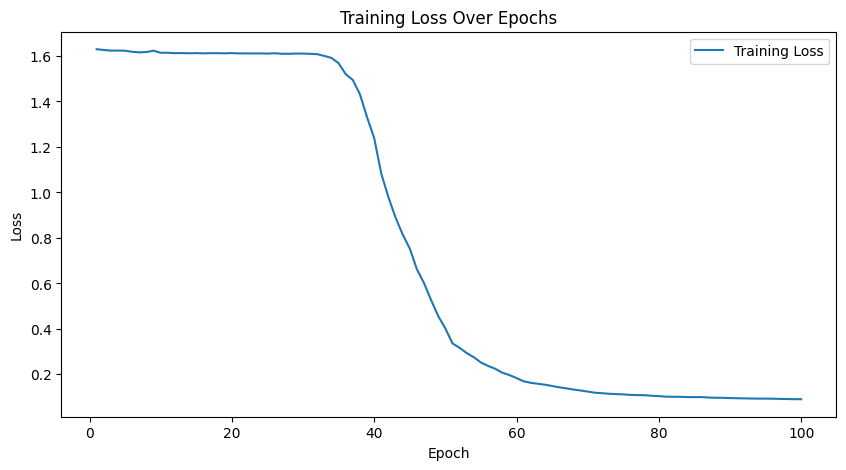

In [50]:
# Plot and save Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.savefig("/kaggle/working/training_loss.png")  # Save the loss plot
plt.show()

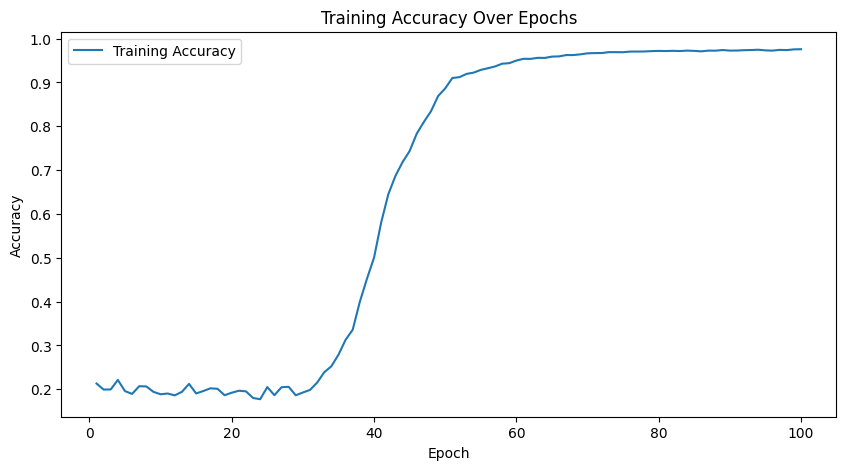

In [51]:
# Plot and save Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.savefig("/kaggle/working/training_accuracy.png")  # Save the accuracy plot
plt.show()

### 7. Testing the Model

In [52]:
# prepare data
test_dataset_ra = MultipleChoiceDataset(preprocessed_df_test_ra, tokenizer)
test_ra_allowed_titles = set(preprocessed_df_test_ra['title'].apply(lambda x: x[0] if isinstance(x, list) and x else None))
output_dir_test_ra = "/kaggle/working/downloaded_gifs_test_ra"
os.makedirs(output_dir_test_ra, exist_ok=True)

# Allowed titles per category
allowed_titles_dict = {
    "test_ra": test_ra_allowed_titles
}

# Output directories for each category
category_dirs = {
    "test_ra": output_dir_test_ra
}

# Generate paired dataset
paired_dataset_test = Paired_Dataset_with_Embeddings(
    tsv_file=tsv_file,
    category_dirs=category_dirs,
    allowed_titles_dict=allowed_titles_dict,
    preprocessed_df_train_ra=preprocessed_df_test_ra,
    train_dataset_ra=test_dataset_ra,
    text_encoder=text_encoder,
    model=model,
    processor=processor,
    device=device,
    max_length=128,
    gif_limit=300
)

# Define a DataLoader for test data
test_loader = DataLoader(
    paired_dataset_test, batch_size=16, shuffle=False, collate_fn=collate_fn
)

Failed to download https://38.media.tumblr.com/3f38f11ce6648b4a9a1a635314e3ad48/tumblr_ndd7topxfn1tj2kheo1_400.gif: HTTPSConnectionPool(host='64.media.tumblr.com', port=443): Read timed out. (read timeout=10)
Failed to download https://31.media.tumblr.com/62a6794f8310c7b6de4989c8a3d4fa1c/tumblr_nqaoqwjrk81uy7pfuo1_500.gif: HTTPSConnectionPool(host='64.media.tumblr.com', port=443): Read timed out. (read timeout=10)
Paired dataset created. Counts per category: {'test_ra': 251}


In [53]:
# directory in wich the trained model is stored
model_dir = '/kaggle/working/cross_modal_transformer.pth'

# Define the model configuration (must match the saved model's configuration)
test_config = CrossModalConfig(
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=8,
    dropout_prob=0.1,
    max_position_embeddings=512,
    num_labels=5,  # Number of classification labels
)

# Initialize the model
cmt_model_test = CrossModalTransformer(test_config).to(device)

# Load the saved model weights
cmt_model_test.load_state_dict(torch.load(model_dir))
cmt_model_test.eval()  # Set the model to evaluation mode
 

<ipython-input-53-51efdb23032e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmt_model_test.load_state_dict(torch.load(model_dir))


CrossModalTransformer(
  (embeddings): CrossModalEmbeddings(
    (text_bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_f

In [54]:
total_correct = 0
total_samples = 0
losses = []
loss_fn = nn.CrossEntropyLoss()

# Put model in evaluation mode
cmt_model_test.eval()

with torch.no_grad():
    for text_embeddings, video_embeddings, labels in test_loader:
        text_embeddings = text_embeddings.to(device)
        video_embeddings = video_embeddings.to(device)
        labels = labels.to(device)

        # Forward pass
        with autocast("cuda"):
            outputs = cmt_model_test(
                text_embeddings=text_embeddings,
                visual_embeddings=video_embeddings,
                text_attention_mask=None,  # Precomputed embeddings don't need attention masks
                labels=labels,
            )

        # Loss
        loss = outputs["loss"]
        losses.append(loss.item())

        # Accuracy
        _, predicted = torch.max(outputs["logits"], dim=1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate test accuracy and loss
test_loss = sum(losses) / len(losses)
test_accuracy = total_correct / total_samples

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 4.0055, Test Accuracy: 0.1936


The test loss and test accuracy indicate that the model's performance on the test set is relatively low. This result is heavily influenced by the limited size of the testing dataset, which includes only 200 video-text pairs.

Given the small number of test samples, the model has fewer opportunities to generalize effectively, leading to reduced accuracy. Additionally, the performance can vary significantly depending on the number of video-text pairs considered for both training and testing. Larger datasets typically allow the model to learn more robust representations, improving overall results.

Future improvements could involve expanding the dataset for both training and testing, as a larger test set would provide a more comprehensive evaluation of the model's generalization capabilities.

### 8. EXPERIMENTS

The above cell was used for the experiments with DistilBERT instead of BERT.
For the experiment with T5-Small instead, the CMT architecture was directly modified in the CrossModalEmbeddings class.

In [ ]:
# This cell was used for the experiments with DistilBERT
class TextEncoderWithDistilBERT(nn.Module):
    def __init__(self, bert_model_name, num_heads, num_layers, max_length, embed_dim, dropout=0.1):
        """
        Initialize the TextEncoder with DistilBERT embeddings and masked attention layers.
        
        Args:
            bert_model_name (str): Name of the pre-trained DistilBERT model.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of masked attention layers.
            max_length (int): Maximum sequence length.
            embed_dim (int): Embedding dimension (should match DistilBERT hidden size).
            dropout (float): Dropout rate for attention layers.
        """
        super(TextEncoderWithDistilBERT, self).__init__()
        # Load pre-trained DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained(bert_model_name)

        # Ensure embeddings match the input dimension
        assert embed_dim == self.distilbert.config.hidden_size, \
            f"embed_dim ({embed_dim}) must match DistilBERT hidden size ({self.distilbert.config.hidden_size})."

        # Masked attention layers
        self.layers = nn.ModuleList([
            MaskedAttention(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])

        # Fully connected output layer
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, input_ids, attention_mask, num_choices=5):
        """
        Forward pass for the TextEncoder with DistilBERT.

        Args:
            input_ids (torch.Tensor): Input token IDs of shape [batch_size, seq_len].
            attention_mask (torch.Tensor): Attention mask of shape [batch_size, seq_len].

        Returns:
            torch.Tensor: Output embeddings of shape [batch_size, seq_len, embed_dim].
        """
        # Get DistilBERT embeddings
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        x = distilbert_output.last_hidden_state  # Shape: [batch_size, seq_len, embed_dim]

        # Pass through masked attention layers
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)

        x = self.fc_out(x)  # Shape: [batch_size*num_choices, seq_len, embed_dim]

        # Final output 
        return x

# Initialize TextEncoder with DistilBERT
text_encoder_db = TextEncoderWithDistilBERT(
    bert_model_name="distilbert-base-uncased",
    num_heads=8,
    num_layers=2,
    max_length=128, 
    embed_dim=768
).to(device)